# Validate the NWChem Atomization Energies
We want to make sure they agree with the Gaussian Efforts

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.simulate import relax_structure, compute_reference_energy, subtract_reference_energies
from moldesign.simulate.thermo import compute_zpe
from qcelemental.models.procedures import QCInputSpecification, Model
from qcelemental.models import Molecule
from qcengine.util import compute_wrapper
from qcengine import compute
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


Reference data

In [2]:
multiplicity = {'H': 2, 'He': 1, 'Li': 2, 'C': 3, 'N': 4, 'O': 3, 'F': 2}

In [3]:
qm9_ref_energies = {'C': -37.846772, 'H': -0.500273, 'O':  -75.064579, 
                    'N': -54.583861, 'Li': -7.491464, 'F':  -99.718730}

## Load QM9 Data
It is the training data for our MPNN

In [4]:
qm9 = pd.concat(pd.read_csv(os.path.join('..', '..', '..', 'notebooks', 'mpnn-atomization-energy', f'{x}.csv'))
                for x in ['train', 'test', 'valid'])

Compute the electronic energy

In [5]:
qm9['u_e'] = qm9['u0'] - qm9['zpe']

## Define the QC Specification
These settings are as close to recreate those from the QM9 paper (using G09) that I could muster. The key difference between NWChem and G09 is that NWChem uses only spherical functions for the $d$ and $f$ orbitals, whereas Gaussian mixes Cartesian and spherical functions.

In [6]:
b3lyp_gaussian = 'slater 0.8 HFexch 0.2 becke88 nonlocal 0.72 vwn_3 0.19 lyp 0.81'
spec = QCInputSpecification(
    model=Model(method='b3lyp', basis='6-31g(2df,p)'),
    keywords={
        "dft__convergence": "energy 1e-8",  # Ensures good convergence for gradient
        "dft__grid": "xfine",  # Should recreate Gaussian's grid
        "basis__spherical": True  # NWChem does not use spherical harmonics for F orbitals by default 
    })

## Compute Reference Energies
It is somehow different between codes

In [7]:
ref_energies = dict((e, compute_reference_energy(e, spec, multiplicity[e], 'nwchem')) for e in tqdm(qm9_ref_energies))

  0%|          | 0/6 [00:00<?, ?it/s]

building CURRENT CORRELATION ENERGY ........................SUCCESS


 33%|███▎      | 2/6 [00:02<00:07,  1.83s/it]

building CURRENT CORRELATION ENERGY ........................SUCCESS


 50%|█████     | 3/6 [00:04<00:05,  1.70s/it]

building CURRENT CORRELATION ENERGY ........................SUCCESS


 67%|██████▋   | 4/6 [00:05<00:03,  1.59s/it]

building CURRENT CORRELATION ENERGY ........................SUCCESS


 83%|████████▎ | 5/6 [00:06<00:01,  1.47s/it]

building CURRENT CORRELATION ENERGY ........................SUCCESS


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]

building CURRENT CORRELATION ENERGY ........................SUCCESS


In [8]:
all_ref_energies = pd.DataFrame({'nwchem': ref_energies, 'qm9': qm9_ref_energies})

In [9]:
all_ref_energies['diff'] = all_ref_energies['nwchem'] - all_ref_energies['qm9']

In [10]:
all_ref_energies

,nwchem,qm9,diff
C,-37.844958,-37.846772,1.813503e-03
H,-0.500273,-0.500273,2.175780e-07
O,-75.060582,-75.064579,3.996706e-03
N,-54.582876,-54.583861,9.853928e-04
Li,-7.490902,-7.491464,5.616931e-04
F,-99.715958,-99.718730,2.771869e-03


## Evaluate Atomization Energies
For a few molecules, to see if NWChem agrees with G09. We pick the smallest molecules to minimize computational cost

In [11]:
test_rows = qm9.sort_values('n_heavy_atoms', ascending=True).query('n_heavy_atoms<6').head(32)
print(f'Selected {len(test_rows)} molecules')

Selected 32 molecules


### Single-point energy calculation
Use the Gaussian geometry

In [12]:
test_rows['nwchem_single_u_e'] = None
test_rows['nwchem_single_grads'] = None

In [13]:
for rid, row in tqdm(test_rows.iterrows()):
    with compute_wrapper(raise_error=True):
        result = compute({
            'molecule': Molecule.from_data(row['xyz'], fix_symmetry='c1'),
            'driver': 'gradient',
            **spec.dict(exclude={'driver'})
        }, 'nwchem', raise_error=True)
    test_rows.loc[rid, 'nwchem_single_u_e'] = result.properties.return_energy
    test_rows.loc[rid, 'nwchem_single_grads'] = np.abs(result.return_result).max()

32it [35:59, 67.49s/it] 


Plot the differences in total energy. 

Text(0, 0.5, 'Frequency')

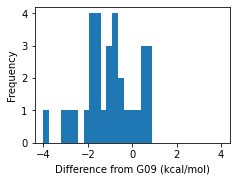

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

errors = (test_rows['u_e'] - test_rows['nwchem_single_u_e']) * 627.50947406
ax.hist(errors, bins=np.linspace(-4, 4, 32))
ax.set_xlabel('Difference from G09 (kcal/mol)')
ax.set_ylabel('Frequency')

*Finding*: They are pretty large. Several kcal/mol is way too large for our application

Checking the atomization energy

In [15]:
test_rows['nwchem_single_u_e_atom'] = test_rows.apply(lambda x: subtract_reference_energies(
    x['nwchem_single_u_e'], Molecule.from_data(x['xyz']), ref_energies
), axis=1)

In [16]:
test_rows['u_e_atom'] = test_rows.apply(lambda x: subtract_reference_energies(
    x['u_e'], Molecule.from_data(x['xyz']), qm9_ref_energies
), axis=1)

Text(0, 0.5, 'Frequency')

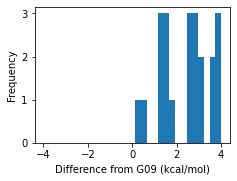

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

errors = (test_rows['u_e_atom'] - test_rows['nwchem_single_u_e_atom']) * 627.50947406
ax.hist(errors, bins=np.linspace(-4, 4, 32))
ax.set_xlabel('Difference from G09 (kcal/mol)')
ax.set_ylabel('Frequency')

### Geometry Calculations
See how much "worse" agreement is when we start from the SMILES string. The `relax_structure` argument generates the molecule geometry using RDKit and then relaxes it with NWChem

In [18]:
for rid, row in tqdm(test_rows.iterrows()):
    try:
        with compute_wrapper(raise_error=True):
            mol, eng = relax_structure(row['smiles_0'], spec)
    except:
        continue
    test_rows.loc[rid, 'nwchem_u_e'] = eng
    test_rows.loc[rid, 'nwchem_xyz'] = mol.final_molecule.to_string('xyz')

32it [3:51:25, 433.92s/it] 


In [19]:
failed = test_rows['nwchem_u_e'].isnull()
print(f'{failed.sum()}/{len(failed)} ({failed.mean() * 100:.1f}%) of relaxations failed')
test_rows = test_rows[~failed]

See how much the NWChem energies are different with a structure minimized with NWChem

Text(0, 0.5, 'Frequency')

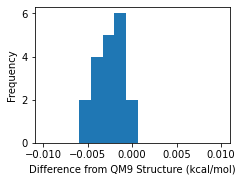

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

errors = (test_rows['nwchem_u_e'] - test_rows['nwchem_single_u_e']) * 627.50947406
ax.hist(errors, bins=np.linspace(-0.01, 0.01, 16))
ax.set_xlabel('Difference from QM9 Structure (kcal/mol)')
ax.set_ylabel('Frequency')

*Finding*: We seem to converge on the same structure at least. Changes are in the ~0.001 kcal/mol range

See how different the geometries are, based on RMSD

In [21]:
test_rows['rmsd'] = test_rows.apply(
    lambda x: Molecule.from_data(x['xyz']).align(Molecule.from_data(x['nwchem_xyz']))[1]['rmsd'], 
    axis=1)

Text(0, 0.5, 'Frequency')

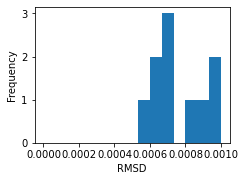

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(test_rows['rmsd'], bins=np.linspace(0, 0.001, 16))
ax.set_xlabel('RMSD')
ax.set_ylabel('Frequency')

*Finding*: They are pretty close. These are very small differences

Does relaxation affect the gradients?

In [23]:
test_rows['nwchem_grads'] = None

In [24]:
for rid, row in tqdm(test_rows.iterrows()):
    with compute_wrapper(raise_error=True):
        result = compute({
            'molecule': Molecule.from_data(row['nwchem_xyz'], fix_symmetry='c1'),
            'driver': 'gradient',
            **spec.dict(exclude={'driver'})
        }, 'nwchem', raise_error=True)
    test_rows.loc[rid, 'nwchem_grads'] = np.abs(result.return_result).max()

Text(0, 0.5, 'Frequency')

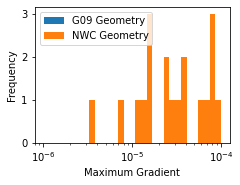

In [25]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

bins = np.logspace(-6, -4, 32)

ax.hist(test_rows['nwchem_single_grads'], bins=bins, label='G09 Geometry')
ax.hist(test_rows['nwchem_grads'], bins=bins, label='NWC Geometry')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Maximum Gradient')
ax.set_ylabel('Frequency')

*Finding*: No perceptible changes in the maximum gradient

Does it actually affect the atomization energy?

In [26]:
test_rows['nwchem_u_e_atom'] = test_rows.apply(lambda x: subtract_reference_energies(
    x['nwchem_u_e'], Molecule.from_data(x['xyz']), ref_energies
), axis=1)

Text(0, 0.5, 'Frequency')

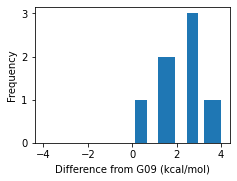

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

errors = (test_rows['u_e_atom'] - test_rows['nwchem_u_e_atom']) * 627.50947406
ax.hist(errors, bins=np.linspace(-4, 4, 32))
ax.set_xlabel('Difference from G09 (kcal/mol)')
ax.set_ylabel('Frequency')

*Finding*: Not enough to make the agreement look any better

## Include ZPE
See how different the energies are when we add zero point energy

In [28]:
test_rows['nwchem_zpe'] = None
for rid, row in tqdm(test_rows.iterrows()):
    with compute_wrapper(raise_error=True):
        result = compute({
            'molecule': Molecule.from_data(row['nwchem_xyz']),
            'driver': 'hessian',
            **spec.dict(exclude={'driver'})
        }, 'nwchem', raise_error=True)
        zpe = compute_zpe(result.return_result, result.molecule)
        test_rows.loc[rid, 'nwchem_zpe'] = zpe

Text(0.5, 0, 'Difference (kcal/mol)')

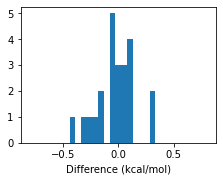

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

diff = (test_rows['nwchem_zpe'] - test_rows['zpe']) * 627.50947406
ax.hist(diff, np.linspace(-0.8, 0.8, 32))

ax.set_xlabel('Difference (kcal/mol)')

*Finding*: The differences are pretty small compared to the total energy